<a href="https://colab.research.google.com/github/laboratoriodecodigos/Colab-Python/blob/main/Redes_Bayesianas_PyAgrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyagrum

In [ ]:
#Imports
import pyagrum as gum
import pyagrum.lib.notebook as gnb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
# 3. Cargar datos
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
df = pd.concat([X, y], axis=1)
print("Tamaño del dataset:", df.shape)

Tamaño del dataset: (569, 31)


In [ ]:
# 4. Selección de variables relevantes
selected_features = [
    'mean radius', 'mean texture', 'mean perimeter',
    'mean area', 'mean smoothness'
]
df = df[selected_features + ['target']].copy()

In [ ]:
# 5. Discretización (Bayes requiere categorías discretas)
disc = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
X_disc = pd.DataFrame(disc.fit_transform(df[selected_features]).astype(int),
                      columns=selected_features)
df_disc = pd.concat([X_disc, df['target']], axis=1)
df_disc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,target
0,2,0,2,2,2,0
1,2,1,2,2,0,0
2,2,2,2,2,2,0
3,0,1,0,0,2,0
4,2,0,2,2,1,0


In [ ]:
# 6. Entrenamiento / prueba
train_df, test_df = train_test_split(df_disc, test_size=0.3, random_state=42)

In [ ]:
# Aprendizaje de estructura y parámetros
learner = gum.BNLearner(train_df, "target")
learner.useLocalSearchWithTabuList()   # Búsqueda local HillClimb con lista Tabu
bn = learner.learnBN()

print("Estructura aprendida:")
print(bn)

Estructura aprendida:
BN{nodes: 6, arcs: 6, domainSize: 486, dim: 37, mem: 456o}


In [ ]:
print(bn)

BN{nodes: 6, arcs: 6, domainSize: 486, dim: 37, mem: 456o}


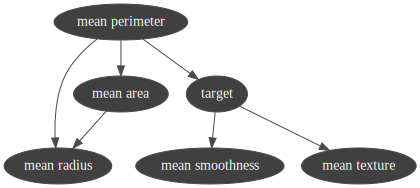

In [ ]:
# Visualización del grafo
gnb.showBN(bn, size="8")

In [ ]:
# Inferencia
ie = gum.LazyPropagation(bn)

def predict_bn(test_df, model, inference_engine):
    preds = []
    probs = []
    for i, row in test_df.iterrows():
        evidence = {col: int(row[col]) for col in selected_features}
        inference_engine.setEvidence(evidence)
        inference_engine.makeInference()
        p = inference_engine.posterior("target")[1]
        preds.append(1 if p >= 0.5 else 0)
        probs.append(p)
    return np.array(preds), np.array(probs)


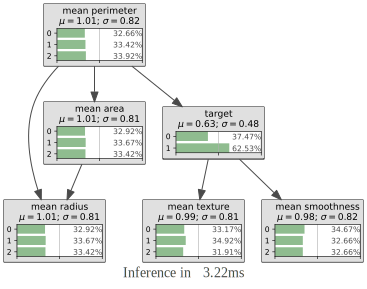

In [ ]:
gnb.showInference(bn,evs={})

In [ ]:
# Predicciones
y_true = test_df['target'].values
preds, probs = predict_bn(test_df, bn, ie)

# Evaluación
acc = accuracy_score(y_true, preds)
auc = roc_auc_score(y_true, probs)

print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.9591
AUC: 0.9858


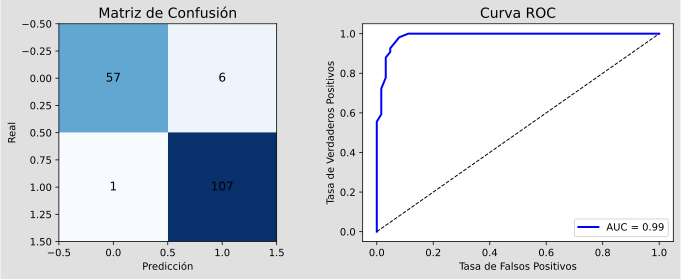

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

# --- 1️⃣ Matriz de confusión ---
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(cm, cmap='Blues')
plt.title("Matriz de Confusión", fontsize=14)
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12)

# --- 2️⃣ Curva ROC ---
fpr, tpr, _ = roc_curve(y_true, probs)
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC", fontsize=14)
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("evaluacion_bn.png", dpi=150)
plt.show()


In [ ]:
# Inferencia ejemplo
sample = test_df.iloc[0]
evidence = {col: int(sample[col]) for col in selected_features}
ie.setEvidence(evidence)
ie.makeInference()
print("\nEvidencia de ejemplo:", evidence)
ie.posterior("target")


Evidencia de ejemplo: {'mean radius': 1, 'mean texture': 1, 'mean perimeter': 1, 'mean area': 1, 'mean smoothness': 1}


(pyagrum.Tensor@0x1107eea0) 
  target           |
0        |1        |
---------|---------|
 0.2520  | 0.7480  |

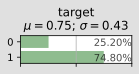

In [ ]:
gnb.showPosterior(bn, evs=evidence, target="target")